In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import cm
import json
import sys
import os
import glob
# make paths above 'notebooks/' visible for local imports.
# +----------------------------------------------------------------------------+
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.processing import GatherFeatureDatasets
from src.feature_selection import CustomRFECV
from src import plotting
from src.utils import select_N_one_standard_error

# Load results

In [2]:
datadir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/feature_selection/rfecvS_diffSeeds'
proc = GatherFeatureDatasets(is_p=False)

In [3]:
feature_names = proc.get_feature_names(18, 'dist', False)
feature_names

array(['amp_ratio_1', 'amp_ratio_2', 'amp_ratio_3', 'amp_ratio_4',
       'amp_ratio_5', 'amp_ratio_6', 'amp_ratio_7', 'amp_ratio_8',
       'amp_ratio_9', 'amp_ratio_10', 'amp_ratio_11', 'amp_ratio_12',
       'amp_ratio_13', 'amp_ratio_14', 'amp_ratio_15', 'amp_ratio_16',
       'amp_ratio_17', 'amp_ratio_18', 'amp_1', 'amp_2', 'amp_3', 'amp_4',
       'amp_5', 'amp_6', 'amp_7', 'amp_8', 'amp_9', 'amp_10', 'amp_11',
       'amp_12', 'amp_13', 'amp_14', 'amp_15', 'amp_16', 'amp_17',
       'amp_18', 'signal_dominant_frequency', 'signal_dominant_amplitude',
       'noise_max_amplitude', 'signal_max_amplitude', 'signal_variance',
       'noise_variance', 'source_depth_km',
       'source_receiver_distance_logkm',
       'source_receiver_back_azimuth_deg'], dtype='<U32')

In [4]:
feature_plot_names = proc.get_feature_plot_names(18, 'dist')
feature_plot_names

array(['ratio 1', 'ratio 2', 'ratio 3', 'ratio 4', 'ratio 5', 'ratio 6',
       'ratio 7', 'ratio 8', 'ratio 9', 'ratio 10', 'ratio 11',
       'ratio 12', 'ratio 13', 'ratio 14', 'ratio 15', 'ratio 16',
       'ratio 17', 'ratio 18', 'amp. 1', 'amp. 2', 'amp. 3', 'amp. 4',
       'amp. 5', 'amp. 6', 'amp. 7', 'amp. 8', 'amp. 9', 'amp. 10',
       'amp. 11', 'amp. 12', 'amp. 13', 'amp. 14', 'amp. 15', 'amp. 16',
       'amp. 17', 'amp. 18', 'sig. dom. freq.', 'sig. dom. amp.',
       'noise max. amp.', 'sig. max. amp.', 'sig. var.', 'noise var.',
       'depth', 'distance', 'back az.'], dtype='<U15')

In [5]:
with open(os.path.join(datadir, 'all.SVR.DT.rel.rfecv.json')) as fp:
    rfecv_results_dict = json.load(fp)

In [6]:
with open(os.path.join(datadir, 'all.SVR.DT.rel.rfe.full.json')) as fp:
    full_rfe_results_dict = json.load(fp)

# Results summary

In [7]:
plotting.set_default_fontsizes()

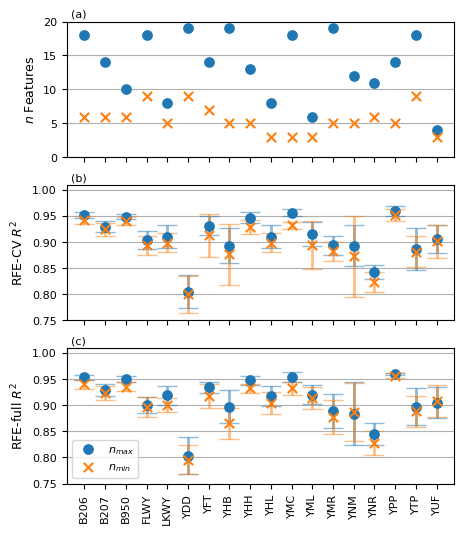

In [8]:
plotting.plot_rfecv_score_summary(rfecv_results_dict, 
                                    full_rfe_results_dict,
                                    capsize=7,
                                    score_ylims=[0.75, 1.01],
                                    grids=True,
                                    elinewidth=2,
                                    s=45,
                                    plot_N=True,
                                    N_ylims=[0, 20],
                                    figsize=(5, 6),
                                    savefigname='../figures/RFE_summary_S.png')

# RFECV Results - Best *N*

# 

In [8]:
# Save without filtering out zero rows
best_feat_cnts_df = CustomRFECV.make_feature_count_df(rfecv_results_dict, 
                                          feature_plot_names,
                                          CustomRFECV.get_rfecv_important_feature_counts,
                                          filter_zeros=False)
best_feat_cnts_df.to_csv(os.path.join(datadir, 'feature.importance.rfecv.best.csv'))

best_feat_cnts_df = best_feat_cnts_df.loc[~(best_feat_cnts_df==0).all(axis=1)]

In [9]:
best_feat_summary_df = CustomRFECV.get_feature_cnts_across_stats(best_feat_cnts_df)
best_feat_summary_df

,Feature,cnt
37,distance,180
36,depth,156
38,back az.,144
19,amp. 2,142
35,noise var.,131
21,amp. 4,128
18,amp. 1,111
34,sig. var.,111
32,noise max. amp.,97
20,amp. 3,97


In [10]:
best_feat_summary_df[best_feat_summary_df.cnt > best_feat_summary_df['cnt'].quantile(0.75)]

,Feature,cnt
37,distance,180
36,depth,156
38,back az.,144
19,amp. 2,142
35,noise var.,131
21,amp. 4,128
18,amp. 1,111
34,sig. var.,111
32,noise max. amp.,97
20,amp. 3,97


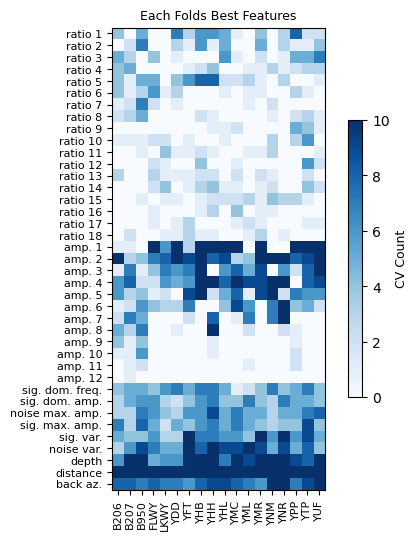

In [11]:
plotting.plot_rfecv_feature_heatmap(best_feat_cnts_df,
                                    figsize=(6, 6),
                                    title='Each Folds Best Features')

# RFECV Results 1 St. Error *N*

In [12]:
# Save without filtering out zero rows
oste_feat_cnts_df = CustomRFECV.make_feature_count_df(rfecv_results_dict, 
                      feature_plot_names,
                      CustomRFECV.get_rfecv_important_feature_counts,
                      oste_feats=True,
                      filter_zeros=False)
oste_feat_cnts_df.to_csv(os.path.join(datadir, 'feature.importance.rfecv.oste.csv'))
oste_feat_cnts_df = oste_feat_cnts_df.loc[~(oste_feat_cnts_df==0).all(axis=1)]

In [13]:
oste_feat_summary_df = CustomRFECV.get_feature_cnts_across_stats(oste_feat_cnts_df)
oste_feat_summary_df

,Feature,cnt
34,distance,160
16,amp. 1,99
17,amp. 2,97
19,amp. 4,84
33,depth,60
18,amp. 3,56
20,amp. 5,47
21,amp. 6,32
31,sig. var.,31
35,back az.,31


In [14]:
oste_feat_summary_df[oste_feat_summary_df.cnt > oste_feat_summary_df['cnt'].quantile(0.75)]

,Feature,cnt
34,distance,160
16,amp. 1,99
17,amp. 2,97
19,amp. 4,84
33,depth,60
18,amp. 3,56
20,amp. 5,47
21,amp. 6,32


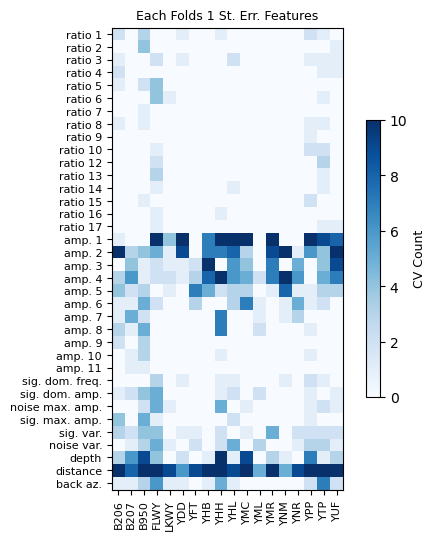

In [15]:
plotting.plot_rfecv_feature_heatmap(oste_feat_cnts_df,
                                    figsize=(6, 6),
                                    title='Each Folds 1 St. Err. Features')

# Best *N* Selected Features from Full Training Sets

In [16]:
selected_best_features_df = CustomRFECV.make_feature_count_df(full_rfe_results_dict, 
                                          feature_plot_names,
                                          CustomRFECV.get_selected_feature_counts,
                                          filter_zeros=False)
selected_best_features_df.to_csv(os.path.join(datadir, 'feature.importance.rfe.full.best.csv'))
selected_best_features_df = selected_best_features_df.loc[~(selected_best_features_df==0).all(axis=1)]

In [17]:
sel_feat_summary_df = CustomRFECV.get_feature_cnts_across_stats(selected_best_features_df)
sel_feat_summary_df

,Feature,cnt
34,distance,18
33,depth,16
19,amp. 4,15
17,amp. 2,15
32,noise var.,15
35,back az.,13
31,sig. var.,12
28,sig. dom. amp.,11
29,noise max. amp.,10
27,sig. dom. freq.,10


In [18]:
sel_feat_summary_df[sel_feat_summary_df.cnt > sel_feat_summary_df['cnt'].quantile(0.75)]

,Feature,cnt
34,distance,18
33,depth,16
19,amp. 4,15
17,amp. 2,15
32,noise var.,15
35,back az.,13
31,sig. var.,12
28,sig. dom. amp.,11


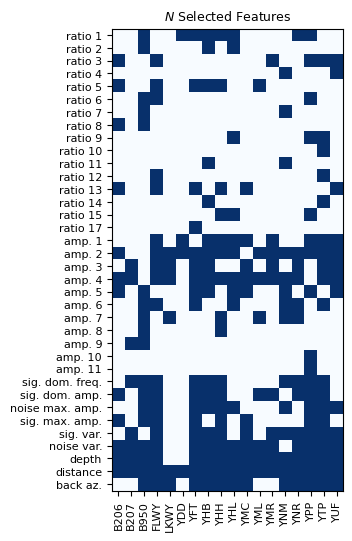

In [19]:
plotting.plot_rfecv_feature_heatmap(selected_best_features_df, 
                                    plot_colorbar=False,
                                    figsize=(5, 6),
                                    title='$\it{N}$ Selected Features')

# 1 St. Err. *N* Selected Features from Full Training Sets

In [20]:
selected_oste_features_df = CustomRFECV.make_feature_count_df(full_rfe_results_dict, 
                                          feature_plot_names,
                                          CustomRFECV.get_selected_feature_counts,
                                          oste_feats=True,
                                          filter_zeros=False)
selected_oste_features_df.to_csv(os.path.join(datadir, 'feature.importance.rfe.full.oste.csv'))
selected_oste_features_df = selected_oste_features_df.loc[~(selected_oste_features_df==0).all(axis=1)]                                         

In [21]:
sel_oste_feat_summary_df = CustomRFECV.get_feature_cnts_across_stats(selected_oste_features_df)
sel_oste_feat_summary_df

,Feature,cnt
19,distance,18
7,amp. 4,12
5,amp. 2,11
4,amp. 1,10
6,amp. 3,8
18,depth,7
8,amp. 5,5
17,noise var.,4
14,sig. dom. amp.,3
16,sig. var.,3


In [22]:
sel_oste_feat_summary_df[sel_oste_feat_summary_df.cnt > sel_oste_feat_summary_df['cnt'].quantile(0.75)]

,Feature,cnt
19,distance,18
7,amp. 4,12
5,amp. 2,11
4,amp. 1,10
6,amp. 3,8


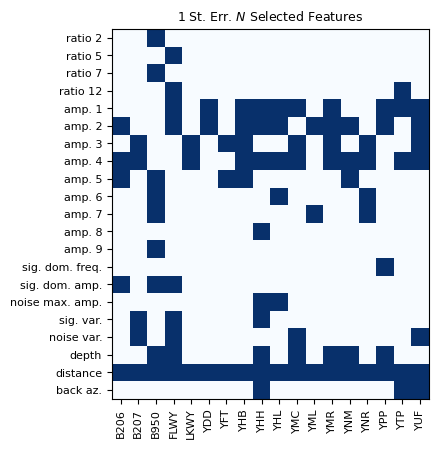

In [23]:
plotting.plot_rfecv_feature_heatmap(selected_oste_features_df, 
                                    plot_colorbar=False,
                                    title='1 St. Err. $\it{N}$ Selected Features')